# Neural style

In [ ]:
style_weight = 5e3
content_weight = 1
variation_weight = 100
iterations = 20


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda")


Download the images

In [ ]:
!wget https://www.tate.org.uk/art/images/work/T/T05/T05010_10.jpg  -O style.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/a/ab/Sad_Woman.jpg/800px-Sad_Woman.jpg  -O base.jpg
base_image_path = 'base.jpg'
style_reference_image_path = 'style.jpg'

base_image = Image.open(base_image_path)
style_reference_image = Image.open(style_reference_image_path)


--2020-07-08 17:06:46--  https://www.tate.org.uk/art/images/work/T/T05/T05010_10.jpg
Resolving www.tate.org.uk (www.tate.org.uk)... 83.231.173.69
Connecting to www.tate.org.uk (www.tate.org.uk)|83.231.173.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 384265 (375K) [image/jpeg]
Saving to: ‘style.jpg’

style.jpg           100%[===================>] 375.26K  --.-KB/s    in 0.09s   

2020-07-08 17:06:47 (3.93 MB/s) - ‘style.jpg’ saved [384265/384265]

--2020-07-08 17:06:49--  https://upload.wikimedia.org/wikipedia/commons/thumb/a/ab/Sad_Woman.jpg/800px-Sad_Woman.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60972 (60K) [image/jpeg]
Saving to: ‘base.jpg’

base.jpg            100%[===================>]  59.54K  --.-KB/s    in 0.02s   

2020-07-08 17:06:49 (2.94 MB/s

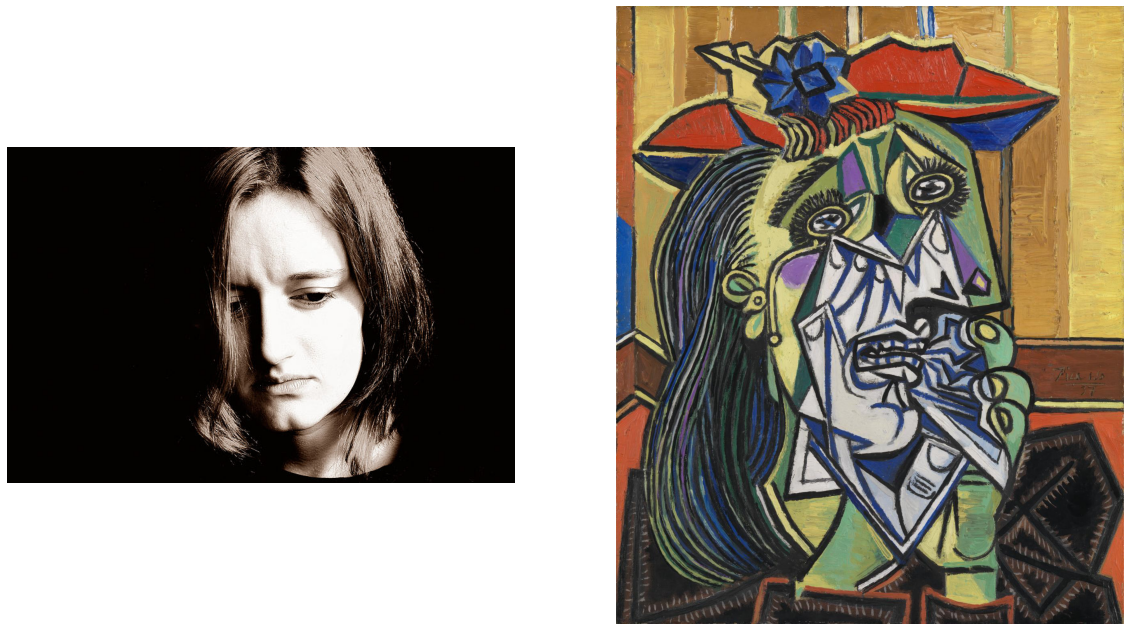

In [ ]:
f, axarr = plt.subplots(1, 2, figsize=(20, 20))
axarr[0].imshow(np.asarray(base_image))
axarr[0].axis('off')
axarr[1].imshow(np.asarray(style_reference_image))
axarr[1].axis('off')
plt.show()


# Model

In [ ]:
from torchvision import models, transforms

model = models.vgg16(pretrained=True)


In [ ]:
model = model.features


In [ ]:
model.to(device)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
content_layers = [21]

style_layers = [0, 5, 10, 17, 24]


## Exercise 1
Complete the code to have a FeaturesExtractor module that returns 2 lists, one with the content and one with the style features.

**Hint:** You can use `for i, layer in enumerate(self.base_model):` to iterate the layers of the model in order one by one.

In [ ]:
import torch.nn as nn
class FeaturesExtractor(nn.Module):

    def __init__(self, base_model, content_layers, style_layers):
        super().__init__()
        self.base_model = base_model
        self.content_layers = content_layers
        self.style_layers = style_layers

    def forward(self, x):
        content_output = []
        style_output = []
        for i, layer in enumerate(self.base_model):
            x = layer(x)
            if i in self.content_layers:
                content_output.append(x)
            if i in self.style_layers:
                style_output.append(x)
                
        return content_output, style_output


In [ ]:
feature_extractor = FeaturesExtractor(model, content_layers, style_layers)
for p in feature_extractor.parameters():
    p.requires_grad = False


# Loss functions

## Exercise 2
Complete the content loss and the style loss.

**Hint:** Remember that the content loss is Mean Square Error for the features, and the style loss is Mean Square Error for the Gram matrices of the features.

In [ ]:
content_loss = nn.MSELoss()

def gram_matrix(x):
    b, c, h, w = x.shape
    x = x.reshape(b, c, h*w)
    gram = torch.bmm(x, x.transpose(1, 2))/(h*w)
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    return F.mse_loss(S, C)


In [ ]:
def total_variation_loss(combination):      
    tv_h = ((combination[:,:,1:,:] - combination[:,:,:-1,:]).pow(2)).mean()
    tv_w = ((combination[:,:,:,1:] - combination[:,:,:,:-1]).pow(2)).mean()    
    return tv_h + tv_w


# Data

In [ ]:
img_size = 512

transform = transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.CenterCrop(img_size),
                                transforms.ToTensor(),
                            ])


In [ ]:
base_tensor = transform(base_image).to(device).unsqueeze(0)
style_reference_tensor = transform(style_reference_image).to(device).unsqueeze(0)


## Exercise 3
Create the `combination_tensor` with the same initial values as base_tensor. It will be the image that we will "train". Then, use `optim.LBFGS` as an optimizer to train it, with the default value for lr.

**Hint:** You can copy another tensor by using `.clone()`. Remember that trainable tensors have to have `requires_grad=True`

In [ ]:
combination_tensor = base_tensor.clone().to(device)
combination_tensor.requires_grad = True

optimizer = optim.LBFGS([combination_tensor])


# Extract target

In [ ]:
content_target, _ = feature_extractor(base_tensor)
_, style_target = feature_extractor(style_reference_tensor)

content_target = [ct.detach() for ct in content_target]
style_target = [st.detach() for st in style_target]


# Training Loop

## Exercise 4

Complete the training loop. 

Take into account that the optimizer LBFGS requires a closure, which is a function that sets the gradients to 0, evaluates the model with the current data, computes the loss, computes the gradients and then returns the current loss. Remember to multiply each loss times the corresponding weight defined in the hyperparameters cell.



In [ ]:

images_history = []

for i in range(iterations):

    def closure():
        # Reset gradients
        optimizer.zero_grad()
        loss = 0.0

        content_output, style_output = feature_extractor(combination_tensor)

        # Content loss
        cl = 0
        for orignal_feature, combination_feature in zip(content_target, content_output):
            cl += content_weight*content_loss(orignal_feature, combination_feature)
        loss += cl / len(content_layers)
        
        # Style loss
        sl = 0
        for orignal_feature, combination_feature in zip(style_target, style_output):
            sl += style_weight*style_loss(orignal_feature, combination_feature)
        loss +=  sl / len(style_layers)

        # Variation loss
        vl = variation_weight*total_variation_loss(combination_tensor)
        loss += vl

        if i % 2 == 0:
            print(f"[{i}] Content loss: {cl.item():.2f}, Style loss: {sl.item():.2f}, Variation loss: {vl.item():.2f}")

        # Compute gradients
        loss.backward()
        return loss
    
    optimizer.step(closure)
    images_history.append(combination_tensor.clone().cpu().squeeze().detach().clamp(0, 1))


[0] Content loss: 1.08, Style loss: 25.42, Variation loss: 1.00
[0] Content loss: 1.08, Style loss: 25.42, Variation loss: 1.00
[0] Content loss: 1.08, Style loss: 25.41, Variation loss: 1.00
[0] Content loss: 1.08, Style loss: 25.41, Variation loss: 1.00
[0] Content loss: 1.08, Style loss: 25.40, Variation loss: 1.00
[0] Content loss: 1.08, Style loss: 25.39, Variation loss: 1.00
[0] Content loss: 1.08, Style loss: 25.38, Variation loss: 1.00
[0] Content loss: 1.08, Style loss: 25.38, Variation loss: 1.00
[0] Content loss: 1.08, Style loss: 25.37, Variation loss: 1.00
[0] Content loss: 1.08, Style loss: 25.37, Variation loss: 1.00
[0] Content loss: 1.08, Style loss: 25.36, Variation loss: 1.00
[0] Content loss: 1.08, Style loss: 25.36, Variation loss: 1.00
[0] Content loss: 1.08, Style loss: 25.35, Variation loss: 0.99
[0] Content loss: 1.08, Style loss: 25.35, Variation loss: 0.99
[0] Content loss: 1.08, Style loss: 25.34, Variation loss: 0.99
[0] Content loss: 1.08, Style loss: 25.3

In [ ]:
images_history = [transforms.functional.to_pil_image(im) for im in images_history]


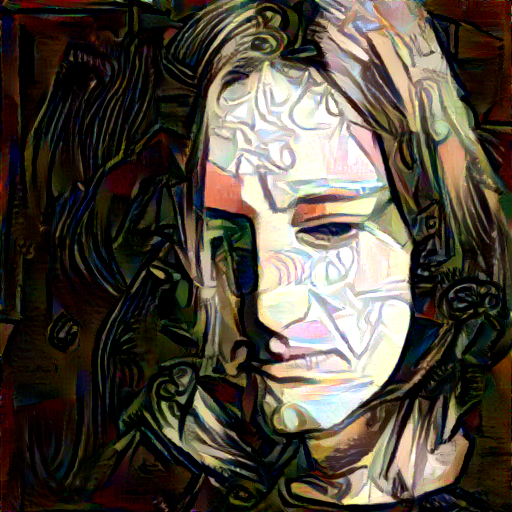

In [ ]:
images_history[19]